Loading Data using torch dataloader

In [48]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
#import matplotlib.pyplot as plt
import skimage
import skimage.io as io
#import glob
import pandas as pd
#%%
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        self.path=path
        self.filenamelist=filenamelist
        self.labellist=labellist
    def __len__(self):
        #return the number of data points
        return len(self.filenamelist)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenamelist[idx])
        I=skimage.util.img_as_float32(I)
        I = I.reshape(1,I.shape[0],I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1],I.shape[2])
        label=torch.tensor(self.labellist[idx], dtype=torch.int64)
        return I, label


In [49]:
#removed from the class for easier access of variables
df_train=pd.read_csv('/content/train.csv')
dataset_train = MyDataset('/content/', df_train['filename'].values, df_train['label'].values)
loader_train = torch_dataloader(dataset_train, batch_size=32, num_workers=0,
                                    shuffle=True, pin_memory=True)
df_test = pd.read_csv('/content/test.csv')
dataset_test = MyDataset('/content/', df_test['filename'].values, df_test['label'].values)
loader_test = torch_dataloader(dataset_test, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)

df_val = pd.read_csv('/content/val.csv')
dataset_val = MyDataset('/content/', df_val['filename'].values, df_val['label'].values)
loader_val = torch_dataloader(dataset_val, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)


Importing resnet and defining model

In [50]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as tv_models


class ScratchNet(nn.Module):
    def __init__(self):
        super().__init__()
        #use resnet50 as the base model
        self.resnet50 = tv_models.resnet50()
        #modified the last layer for binary classification
        self.resnet50.fc=torch.nn.Linear(2048, 2)

    def forward(self,x):
        z = self.resnet50(x)
        return z


In [51]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

Training function

In [52]:
def train(model, device, optimizer, dataloader, epoch):
    model.train()#set model to training mode
    loss_train=0
    acc_train =0
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        Yp=Z.max(dim=-1)[1]
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset)
    return loss_train, acc_train

Test Function

In [53]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            loss = nnF.cross_entropy(Z, Y)
            loss_test+=loss.item()
            Yp=Z.max(dim=-1)[1]
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

# CNN From Scratch

Create a model and starting training/validation/testing 

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=ScratchNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)
#code to update learning rate during training
lr_new=0.0001
for g in optimizer.param_groups:
  g['lr']=lr_new
#---------------------------------------------------------
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
z=model(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cuda:0


In [55]:
def plot_result(loss_train_list, acc_train_list,
                loss_val_list, acc_val_list):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

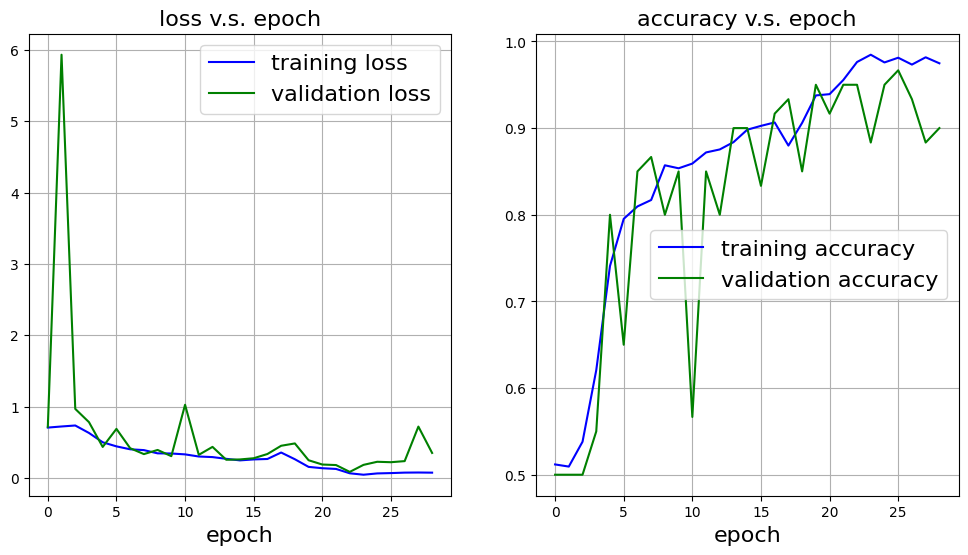

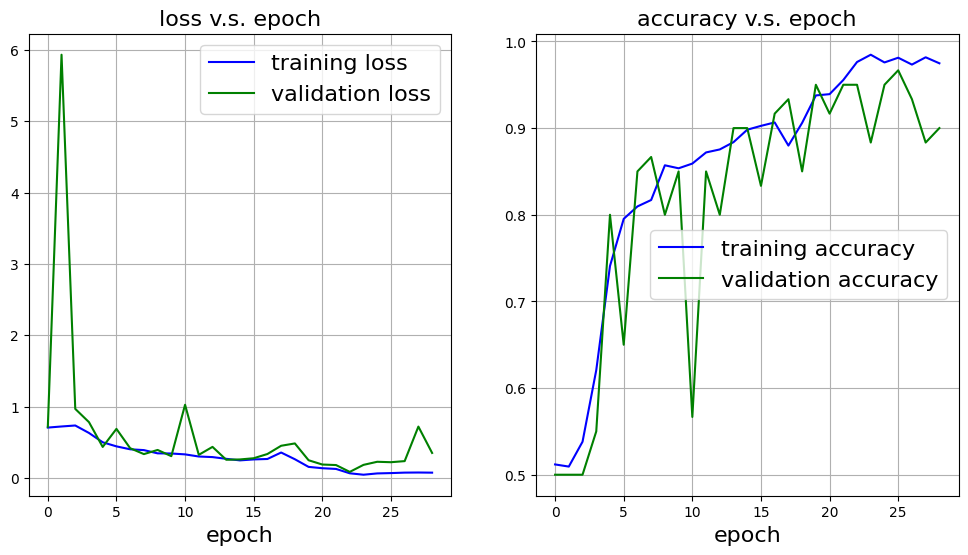

In [56]:
for epoch in range(epoch_save+1, epoch_save+30):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    t1=time.time()
    print("time cost", t1-t0)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list,
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_LS_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list,
                          loss_val_list, acc_val_list)
    display.display(fig)

load the best model

In [57]:
best_epoch= np.argmax(acc_val_list)
best_epoch

25

In [58]:
epoch_save=best_epoch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_LS_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=ScratchNet()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
(loss_train_list, acc_train_list,
 loss_val_list, acc_val_list, other_val) = checkpoint['result']

In [59]:
#calling test with loader_test (changed from examples because we have a test set this time)
loss_val, acc_test, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

Accuracy (average) 0.93
Accuracy (average) 0.93
Sensitivity [0.99 0.87]
Precision [0.88392857 0.98863636]
Confusion_sens 
 [[0.99 0.01]
 [0.13 0.87]]
Confusion_prec 
 [[0.88392857 0.01136364]
 [0.11607143 0.98863636]]


# Transfer Learning


defining model 

In [60]:
from torchvision.models import ResNet50_Weights
tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)
class TransferNet(nn.Module):
    def __init__(self):
        super().__init__()
        #use resnet50 as the base model
        self.resnet50 = tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)
        #modified the last layer for binary classification
        self.resnet50.fc=torch.nn.Linear(2048, 2)
        #freeze all parameters
        for p in self.resnet50.parameters():
            p.requires_grad = False
        #set the parameters of layer4 to be trainable
        for p in self.resnet50.layer4.parameters():
            p.requires_grad = True
        #set the parameters of fc to be trainable
        for p in self.resnet50.fc.parameters():
            p.requires_grad = True

    def get_trainable_parameters(self):
        pList=list(self.resnet50.layer4.parameters())+list(self.resnet50.fc.parameters())
        return pList

    def forward(self,x):
        z = self.resnet50(x)
        return z

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=TransferNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.99)
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#code to update learning rate during training
lr_new=0.0001
for g in optimizer.param_groups:
  g['lr']=lr_new
#---------------------------------------------------------
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
z=model(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cuda:0


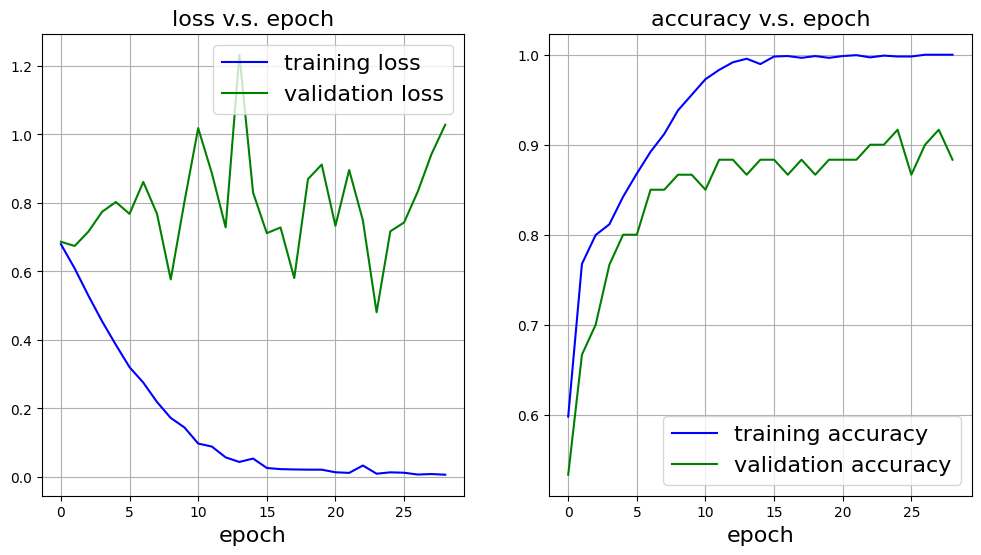

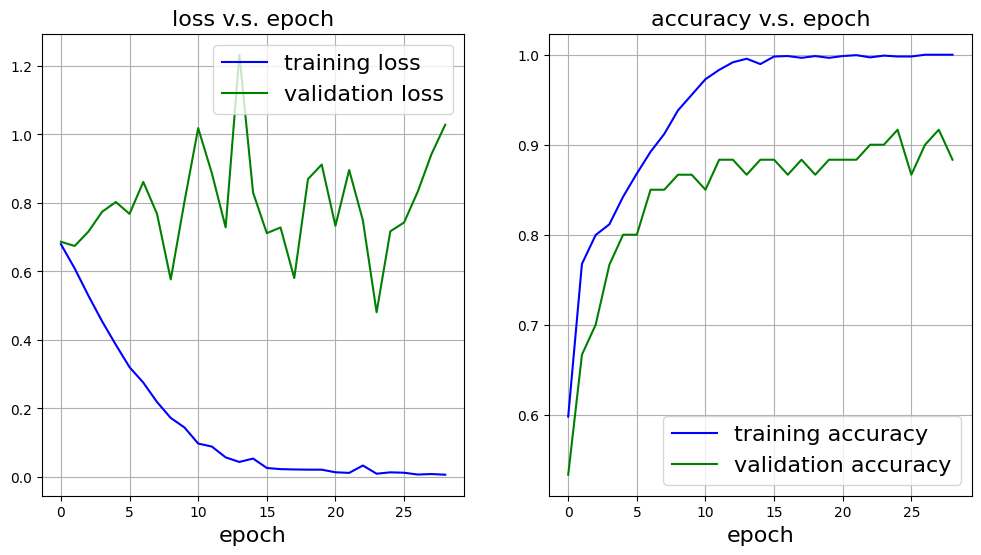

In [62]:
for epoch in range(epoch_save+1, epoch_save+30):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    t1=time.time()
    print("time cost", t1-t0)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list,
              loss_val_list, acc_val_list, other_val)
    save_checkpoint('CNN_TL_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list,
                          loss_val_list, acc_val_list)
    display.display(fig)

In [63]:
best_epoch= np.array(acc_val_list).argmax()
best_epoch

24

In [64]:
epoch_save=best_epoch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_TL_Pytorch_epoch'+str(epoch_save)+'.pt', map_location=device)
model=TransferNet()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
#
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list,
 loss_val_list, acc_val_list, other_val) = checkpoint['result']

In [65]:
#calling test with loader_test (changed from examples because we have a test set this time)
loss_val, acc_val, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_val)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

Accuracy (average) 0.94
Accuracy (average) 0.94
Sensitivity [0.98 0.9 ]
Precision [0.90740741 0.97826087]
Confusion_sens 
 [[0.98 0.02]
 [0.1  0.9 ]]
Confusion_prec 
 [[0.90740741 0.02173913]
 [0.09259259 0.97826087]]


# GradCam and EigenCam for From Scratch Model

In [66]:
#from how_to_use_gradcam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import torch
import matplotlib.pyplot as plt
import skimage

In [67]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

In [68]:
model=ScratchNet()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ScratchNet(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

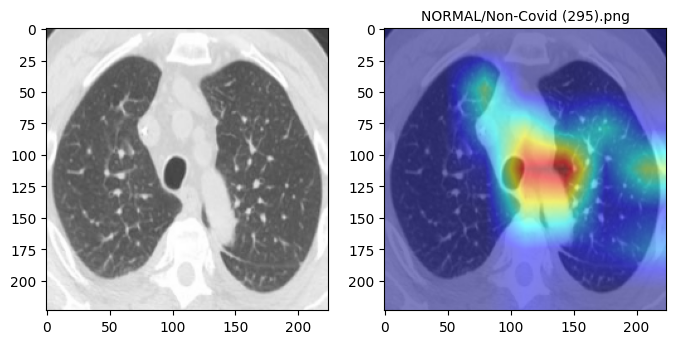

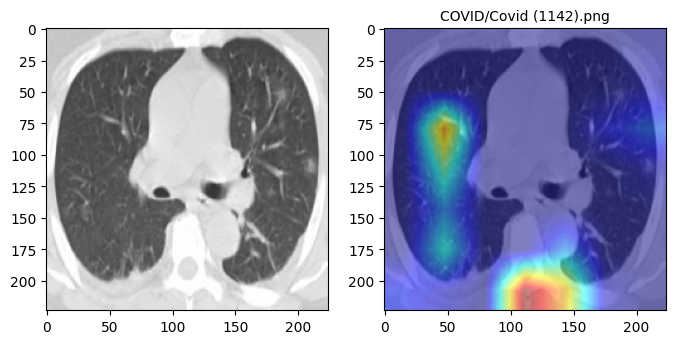

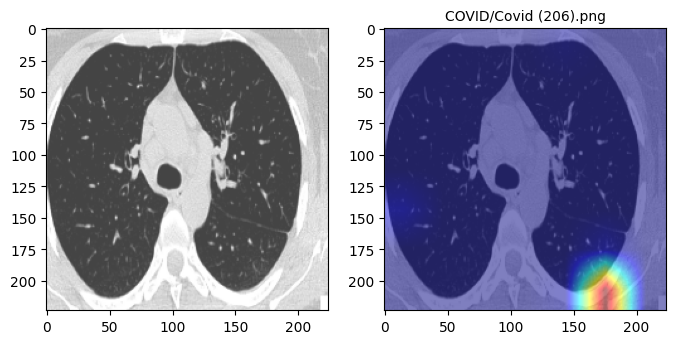

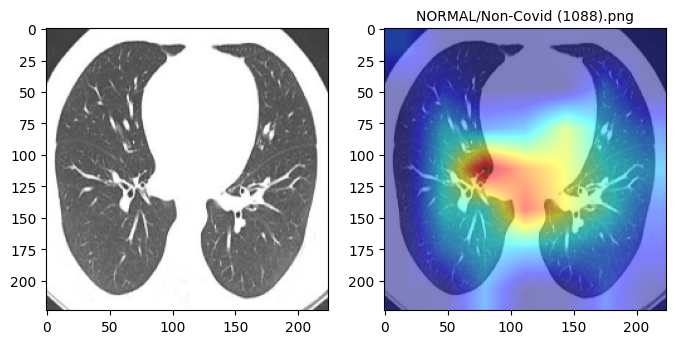

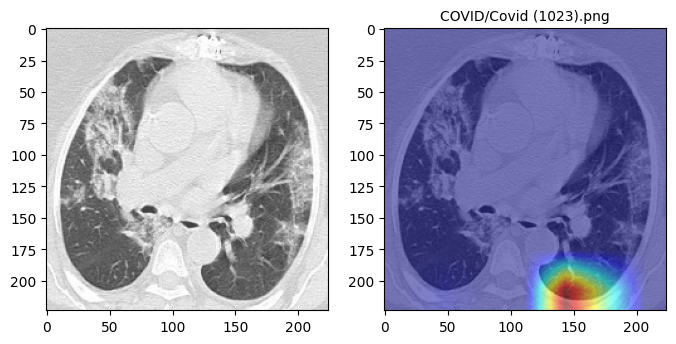

In [69]:
target_layers = [model.resnet50.layer4[-1]]
import random

# Read the test.csv file into a dataframe
test = pd.read_csv('test.csv')

# Extract the paths from the second column
paths = test['filename'].tolist()

# Select 5 random images from the test set
image_paths = random.sample(paths, 5)

for one_test_image_path in image_paths:
  image = skimage.io.imread(one_test_image_path).astype("float32")
  image = image / image.max()
  image=image.reshape(224,224,1)
  image=np.concatenate([image, image, image], axis=2)
  #convert numpy array to pytorch tensor
  image_input=torch.tensor(image).permute(2,0,1) # (224,224,3) to (3,224,224)
  image_input=image_input.reshape(1,3,224,224)
  #GradCAM
  cam = GradCAM(model=model, target_layers=target_layers)
  if(label == "COVID/Covid"):
      category = 1
  else:
      category = 0
  targets = [ClassifierOutputTarget(category=category)]
  grayscale_cam = cam(input_tensor=image_input, targets=targets)
  grayscale_cam=grayscale_cam[0]
  cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
  fig, ax = plt.subplots(1,2, figsize=(8,8))
  #label the image from the test set
  ax[1].set_title(one_test_image_path,fontsize=10)
  ax[0].imshow(image)
  ax[1].imshow(cam_image)

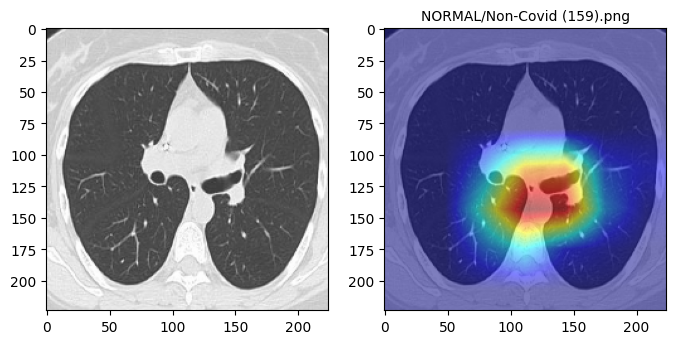

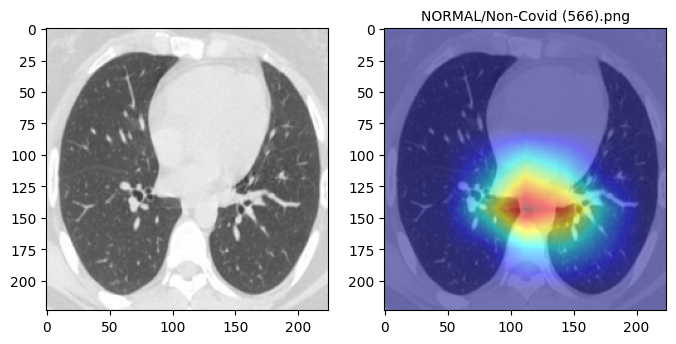

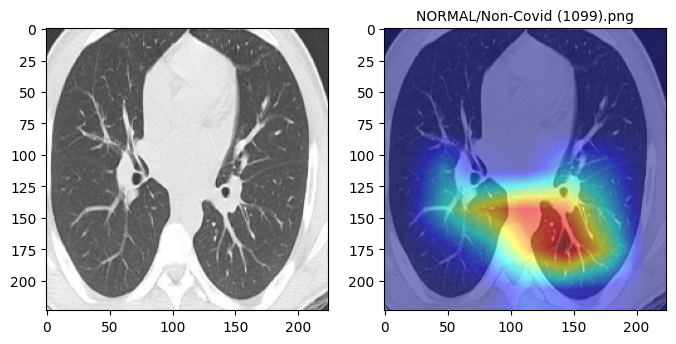

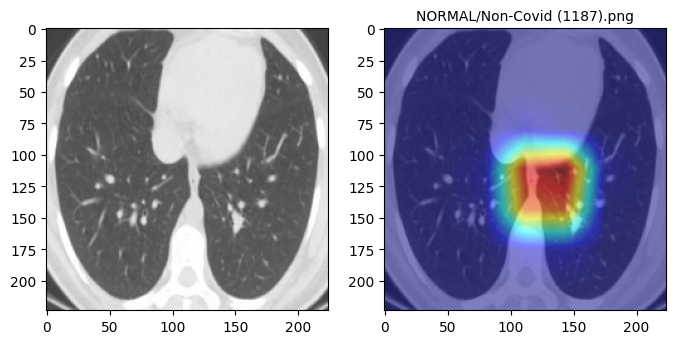

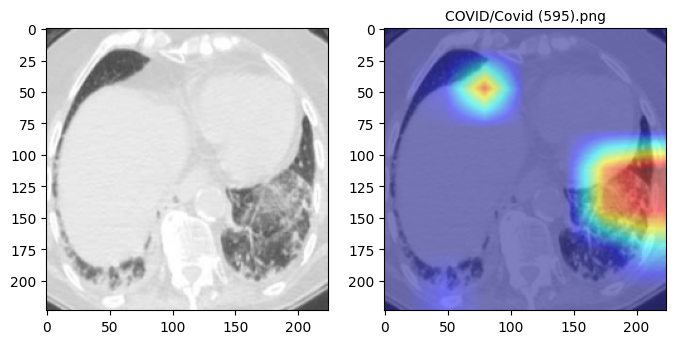

In [70]:
# Select 5 random images from the test set
image_paths = random.sample(paths, 5)

for one_test_image_path in image_paths:
  image = skimage.io.imread(one_test_image_path).astype("float32")
  image = image / image.max()
  image=image.reshape(224,224,1)
  image=np.concatenate([image, image, image], axis=2)
  #convert numpy array to pytorch tensor
  image_input=torch.tensor(image).permute(2,0,1) # (224,224,3) to (3,224,224)
  image_input=image_input.reshape(1,3,224,224)
  #EigenCAM
  cam = EigenCAM(model=model, target_layers=target_layers)
  if(label == "COVID/Covid"):
      category = 1
  else:
      category = 0
  targets = [ClassifierOutputTarget(category=category)]
  grayscale_cam = cam(input_tensor=image_input, targets=targets)
  grayscale_cam=grayscale_cam[0]
  cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
  fig, ax = plt.subplots(1,2, figsize=(8,8))
  #label the image from the test set
  ax[1].set_title(one_test_image_path,fontsize=10)
  ax[0].imshow(image)
  ax[1].imshow(cam_image)

# GradCam and EigenCam for Transfer Learning Model

In [71]:
model=TransferNet()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

TransferNet(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

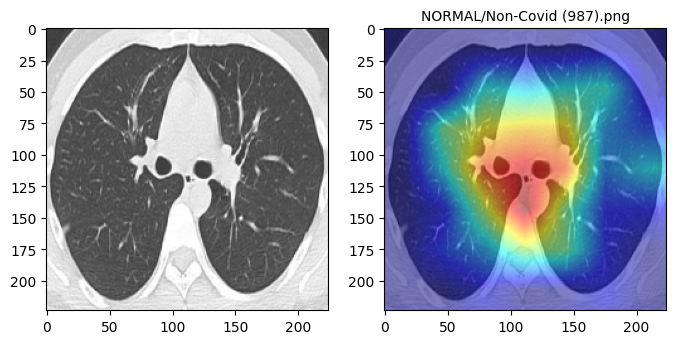

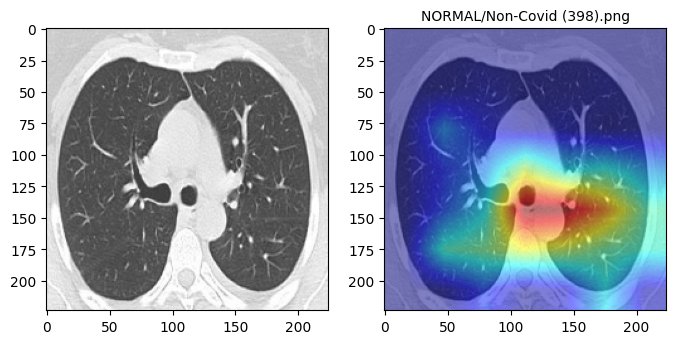

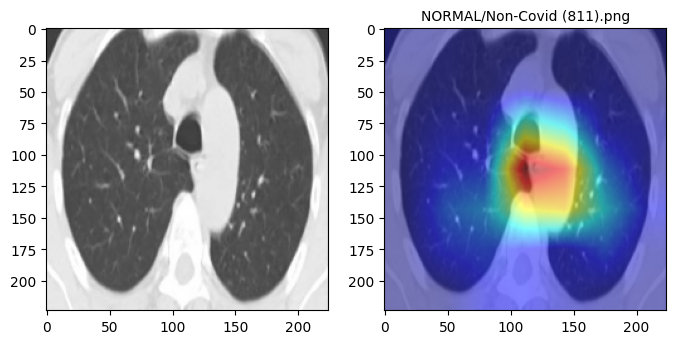

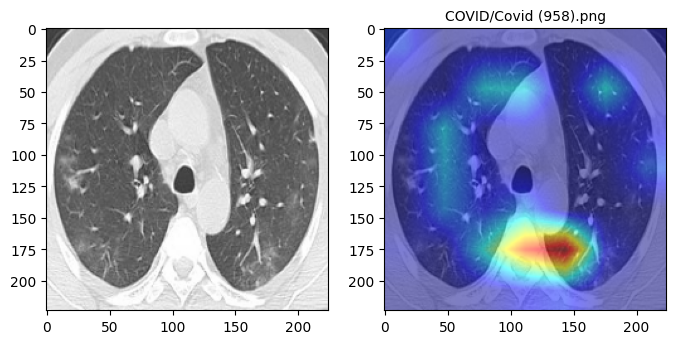

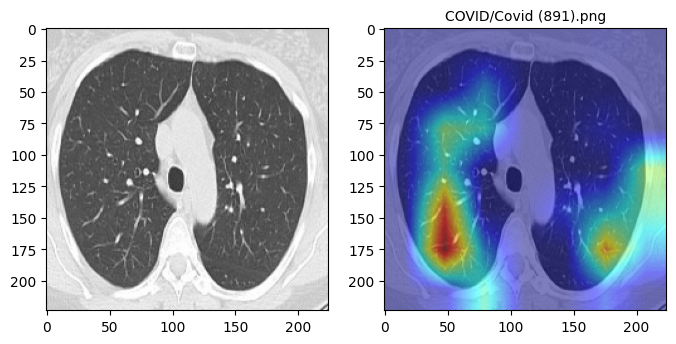

In [73]:
target_layers = [model.resnet50.layer4[-1]]

# Select 5 random images from the test set
image_paths = random.sample(paths, 5)

for one_test_image_path in image_paths:
  image = skimage.io.imread(one_test_image_path).astype("float32")
  image = image / image.max()
  image=image.reshape(224,224,1)
  image=np.concatenate([image, image, image], axis=2)
  #convert numpy array to pytorch tensor
  image_input=torch.tensor(image).permute(2,0,1) # (224,224,3) to (3,224,224)
  image_input=image_input.reshape(1,3,224,224)
  #GradCAM
  cam = GradCAM(model=model, target_layers=target_layers)
  if(label == "COVID/Covid"):
      category = 1
  else:
      category = 0
  targets = [ClassifierOutputTarget(category=category)]
  grayscale_cam = cam(input_tensor=image_input, targets=targets)
  grayscale_cam=grayscale_cam[0]
  cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
  fig, ax = plt.subplots(1,2, figsize=(8,8))
  #label the image from the test set
  ax[1].set_title(one_test_image_path,fontsize=10)
  ax[0].imshow(image)
  ax[1].imshow(cam_image)

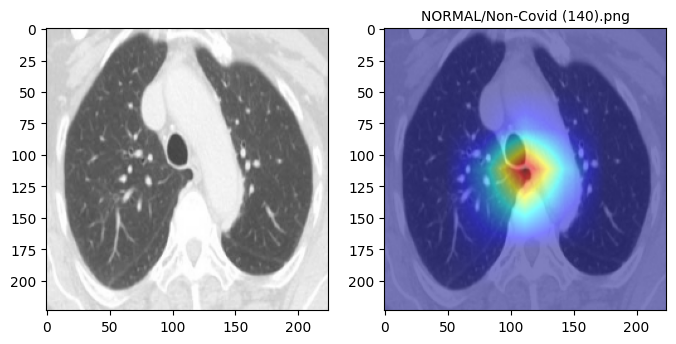

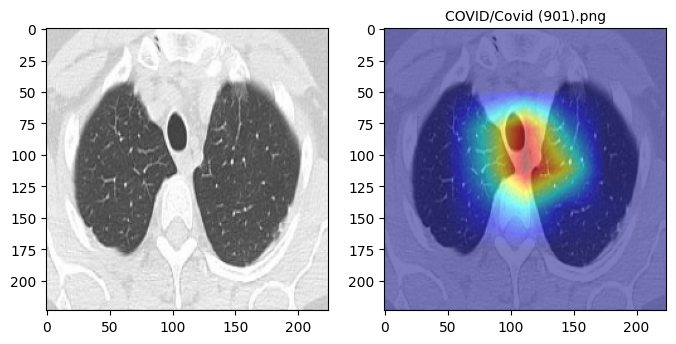

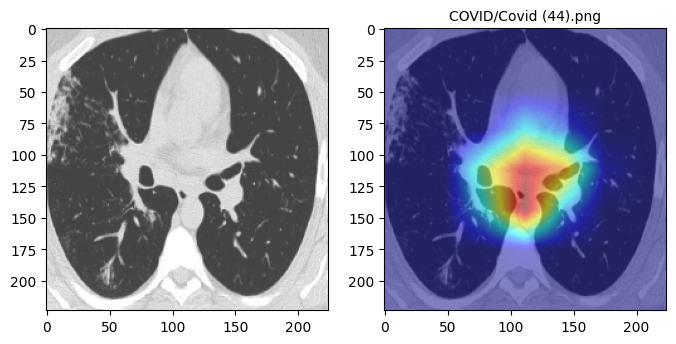

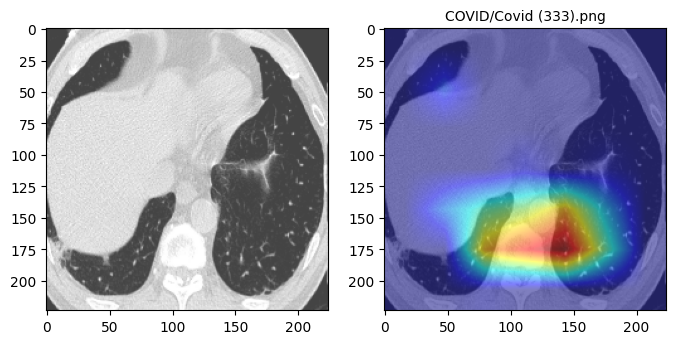

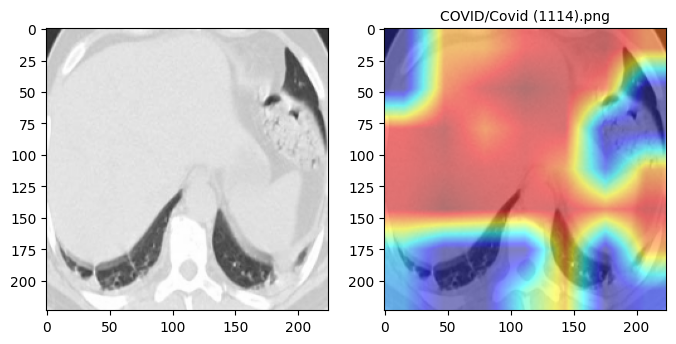

In [74]:
# Select 5 random images from the test set
image_paths = random.sample(paths, 5)

for one_test_image_path in image_paths:
  image = skimage.io.imread(one_test_image_path).astype("float32")
  image = image / image.max()
  image=image.reshape(224,224,1)
  image=np.concatenate([image, image, image], axis=2)
  #convert numpy array to pytorch tensor
  image_input=torch.tensor(image).permute(2,0,1) # (224,224,3) to (3,224,224)
  image_input=image_input.reshape(1,3,224,224)
  #EigenCAM
  cam = EigenCAM(model=model, target_layers=target_layers)
  if(label == "COVID/Covid"):
      category = 1
  else:
      category = 0
  targets = [ClassifierOutputTarget(category=category)]
  grayscale_cam = cam(input_tensor=image_input, targets=targets)
  grayscale_cam=grayscale_cam[0]
  cam_image = show_cam_on_image(image, grayscale_cam, use_rgb=True)
  fig, ax = plt.subplots(1,2, figsize=(8,8))
  #label the image from the test set
  ax[1].set_title(one_test_image_path,fontsize=10)
  ax[0].imshow(image)
  ax[1].imshow(cam_image)